# Applied Machine Learning 2024

This is an introductory piece of code, demonstrating the different ML methods that we are going to be using in the course [Applied Machine Learning 2024](https://www.nbi.dk/~petersen/Teaching/AppliedMachineLearning2024.html).

It is intended for three purposes: Illustration, checking that you have the right Python packages/setup, and finally to wet your appetite.

## Start-up Examples

Below we quickly run several basic examples to check that we have all the most relevant machine learning packages (`pandas`, `scikit-learn`, `tensorflow`, `pytorch`, among some of them).

[Scikit-Learn](https://scikit-learn.org/stable/) provides implementations of a number of machine learning algorithms, as well as [datasets](https://scikit-learn.org/stable/datasets.html) (includeing some used below).

To solve, let's say, a decision boundary problem, we can use a classifier from scikit-learn. For instance, a decision tree classifier. An illustration of one simple tree, that goes only 1 layer deep is shown below. It attempts to separate two types of objects distributed in 2D space that remind two [quarter-moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) (image shown below).

In addition, we can also use `pandas` ([see here](https://pandas.pydata.org/)) to help ourselves with managing data tables, which provides a fast and handy way of working with data tables.

---

#### Authors:
- Vadim Rusakov (Niels Bohr Institute)
- Troels C. Petersen (Niels Bohr Institute)

#### Date:
- 16-04-2024 (latest updated by Johann Ioannou-Nikolaides (Niels Bohr Institute))

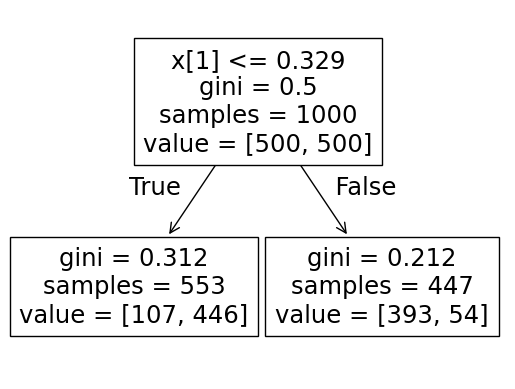

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# create dataset with two classes of objects in some 2D space
data_x, data_y = make_moons(n_samples=1000, noise=0.15, random_state=42)
X = pd.DataFrame(data_x, columns=['x1', 'x2'])
y = pd.Series(data_y, name='class')

# create a decision tree with some depth of 'leafs'
tree_clf = DecisionTreeClassifier(max_depth=1)
tree_clf.fit(X, y)

plot_tree(tree_clf) # visualise tree
plt.rcParams['figure.figsize'] = [10, 6]
plt.show()

In [2]:
# illustrates our data table
pd.concat([X, y], axis=1)

,x1,x2,class
0,-0.081568,0.482211,1
1,1.087333,-0.381159,1
2,0.831725,-0.133135,1
3,0.200339,-0.500300,1
4,-0.824953,0.539526,0
...,...,...,...
995,0.823239,0.481376,0
996,-0.179065,0.873266,0
997,1.705934,-0.388526,1
998,-0.990844,0.199451,0


Train accuracy: 83.90%


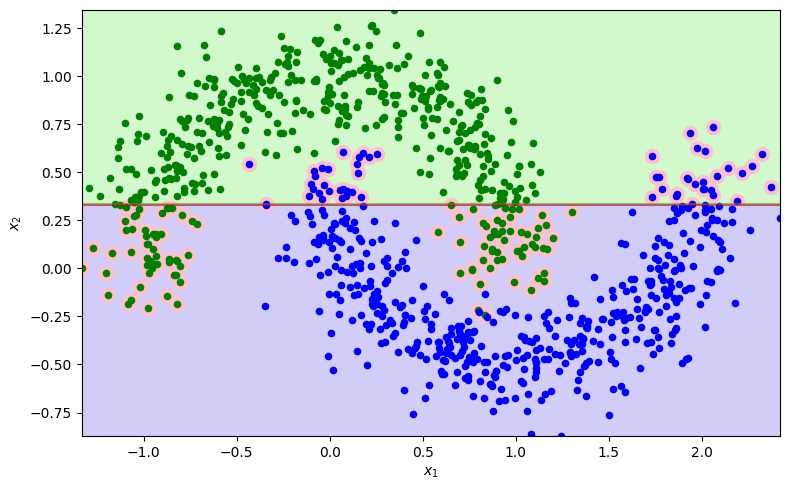

In [3]:
import numpy as np

def plot_boundary_results(X, y, clf):
    # sample the whole X space with a meshgrid of probabilities
    # predicted by out trained classifier
    xx, yy = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 300),
                         np.linspace(X[:,1].min(), X[:,1].max(), 300))
    X_bkg = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1', 'x2'])
    y_bkg = clf.predict_proba(X_bkg)[:, 0].reshape(xx.shape)
    y_pred = clf.predict(pd.DataFrame(X, columns=['x1', 'x2']))

    # plot the classification results
    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.contourf(xx, yy, y_bkg, cmap='brg', alpha=0.2) # coloured by class
    ax.contour(xx, yy, y_bkg, cmap='brg', alpha=0.2) # coloured by class
    ax.scatter(X[:,0][y_pred!=y], X[:,1][y_pred!=y], s=100, c='pink')
    ax.scatter(X[:,0][y==0], X[:,1][y==0], s=20, c='g')
    ax.scatter(X[:,0][y==1], X[:,1][y==1], s=20, c='b')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    plt.tight_layout()
    print(f"Train accuracy: {accuracy_score(y_pred, y)*100.0:.2f}%")

plot_boundary_results(X.values, y.values, tree_clf)

`XGBoost` [(Extreme Gradient Boosting)](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

XGBoost is going to come in handy in various classification and regression tasks that involve decision trees (among, for example, random forests and other boost algorithms). It represents an ensemble of decision trees that is efficient, fast and, therefore, capable of working with large datasets. XGBoost has a scikit-learn-compatible API allowing to use it with a range of learner classes.

Train accuracy: 99.80%


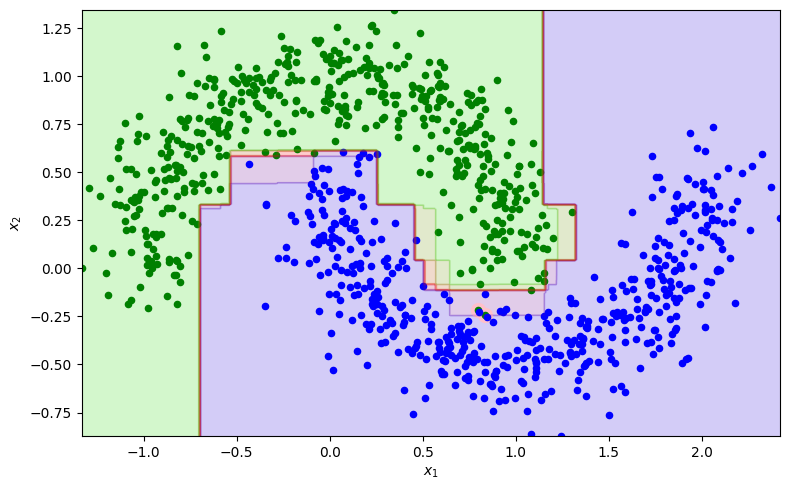

In [4]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.01,
                            max_depth=10, eval_metric='logloss', n_estimators=300,
                            seed=42)
xgb_clf.fit(X, y)
plot_boundary_results(X.values, y.values, xgb_clf)

`LightGBM` ([homepage](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)) is another tree-based learning algorithm with gradient boosting. In contrast to analogous algorithms, it "grows" a tree not by whole rows, but rather leaf-by-leaf, allowing for a finer structure complexity and higher accuracy.

In [5]:
import lightgbm as lgb 

data_train = lgb.Dataset(X, label=y)
params = {'objective': 'binary',
          'boosting_type': 'gbdt',
          'metric': 'binary_logloss',
          'learning_rate': 0.01,
          'num_leaves': 10,
          'max_depth': 10,
          'min_data': 10,
          'verbose': 0,
          'force_col_wise': True}

lgb_clf = lgb.train(params, train_set=data_train, num_boost_round=300)
y_pred = np.around(lgb_clf.predict(X.values))
acc = accuracy_score(y_pred, y)
print(f"Train accuracy: {acc*100.0:.2f}%")

Train accuracy: 99.80%


`tensorflow` ([really nice homepage](https://www.tensorflow.org/overview/)), in turn, is most useful for using deep learning models. It provides a graph framework for performing computations with networks in C++ and easy scripting in python (versions starting from tensorflow 2 can work in 'eager' mode requiring less interaction with the graph structure). For simple tasks it can be easily interfaced with by using `keras`, which is built on top of tensorflow. This is what we do below solving a classification problem with the hand-written digits [dataset](http://yann.lecun.com/exdb/mnist/).

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

2025-04-16 14:00:36.281457: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 14:00:36.317903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744804836.360911  567120 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744804836.376362  567120 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744804836.410057  567120 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [7]:
# load MNIST dataset to the location "~/keras/mnist.npz"
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

# set up the network hyperparameters
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
batch_norm_momentum = 0.9
learning_rate = 0.001
init = tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in')
centropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# network structure
nn_reg = tf.keras.models.Sequential([
  Input(shape=(28, 28)),
  Flatten(),
  Dense(n_hidden1, activation='elu', kernel_initializer=init),
  BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
  Dense(n_hidden2, activation='elu', kernel_initializer=init),
  BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
  Dense(n_outputs, activation='elu', kernel_initializer=init),
  BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True)
])

nn_reg.compile(loss=centropy, optimizer=SGD(learning_rate), metrics=['accuracy'])

2025-04-16 14:00:41.277841: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# train the network for the following number of epochs and batch size
n_epochs = 3
batch_size = 200

history = nn_reg.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val))

Epoch 1/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4122 - loss: 1.8630 - val_accuracy: 0.7642 - val_loss: 0.9636
Epoch 2/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7691 - loss: 0.9655 - val_accuracy: 0.8373 - val_loss: 0.7994
Epoch 3/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8263 - loss: 0.8267 - val_accuracy: 0.8663 - val_loss: 0.7201


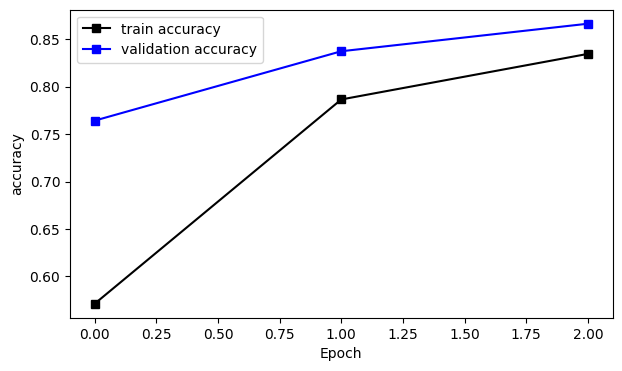

In [9]:
# plot the training and validation accuracy
fig, ax = plt.subplots(1, figsize=(7, 4))
ax.plot(np.arange(n_epochs), history.history['accuracy'], 'ks-', label='train accuracy')
ax.plot(np.arange(n_epochs), history.history['val_accuracy'], 'bs-', label='validation accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 1000x1000 with 0 Axes>

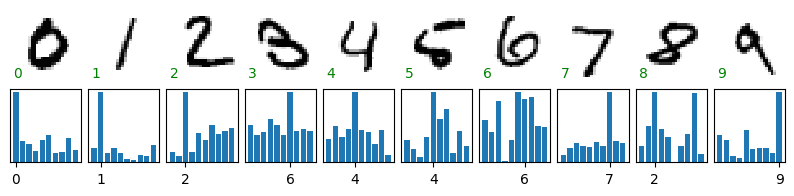

In [10]:
# here we take 10 digits from validation set and see network predictions for them
preds = nn_reg.predict(X_val)
n_digits = len(np.unique(y_val))
n = X_val.shape[-1]

plt.figure(figsize=(10,10))
fig, axes = plt.subplots(2, n_digits, figsize=(10, 2),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

# get digits from validation set in ascending order
n_images = 2 # image of a digit & weighting
#images = np.zeros([n_images * n_digits, n * n])
for i in range(n_digits):
    img =  X_val[np.where(y_val == i)][0].reshape(-1)
    loc = np.where(y_val == i)[0][0]
    img_wht = preds[loc]
    axes[0][i].imshow(img.reshape(n, n), cmap='binary', interpolation='nearest')
    axes[1][i].bar(range(10), np.abs(img_wht))
    axes[0][i].axis("off")
    axes[0][i].text(0.05, 0.05, i, transform=axes[0][i].transAxes, 
                    color='green')
    axes[1][i].set_xticks([np.argmax(img_wht)])

Finally, let us check that `pytorch` ([nice and helpful homepage too](https://pytorch.org/)) is installed with the similar example. This package has 'eager' API execution that was adopted by tensorflow 2, which makes it very native and python-like in writing scripts.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torchvision.datasets import CIFAR10
from torchvision import transforms

Let's set up the model and the hyperparameters

In [12]:
# You can change the number of epochs for a faster result
n_epochs = 5
batch_size = 1000

train_set = CIFAR10('./', download=True, transform=transforms.Compose([transforms.ToTensor(),]), train=True)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

# network structure
n_inputs = 32 * 32 * 3
model = nn.Sequential(nn.Linear(n_inputs, n_hidden1),
                      nn.ReLU(),
                      nn.Linear(n_hidden1, n_hidden2),
                      nn.ReLU(),
                      nn.Linear(n_hidden2, n_outputs),
                      nn.ReLU())

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

Let's set up a validaiton/ test set to visualize the progress

In [13]:
validation_set = CIFAR10('./', download=True, transform=transforms.Compose([transforms.ToTensor(),]), train=False)

# CIFAR-10 class labels
class_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Find the first image of each class for validation
first_images = {}
for idx, (image, label) in enumerate(validation_set):
    if label not in first_images:
        first_images[label] = (image, label)
    if len(first_images) == len(class_labels):
        break

Note that training takes some time to run, but we will be plotting the prediction on the digits again to visualize the training progress

Epoch 1 - training loss: 0.00228


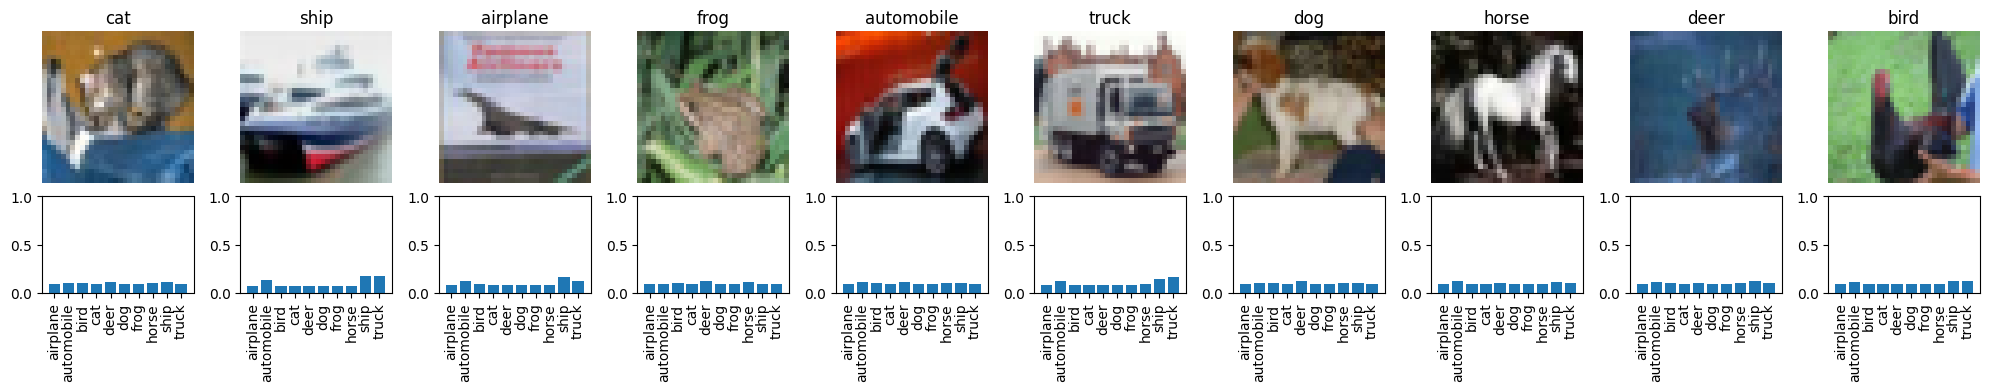

Epoch 2 - training loss: 0.00220


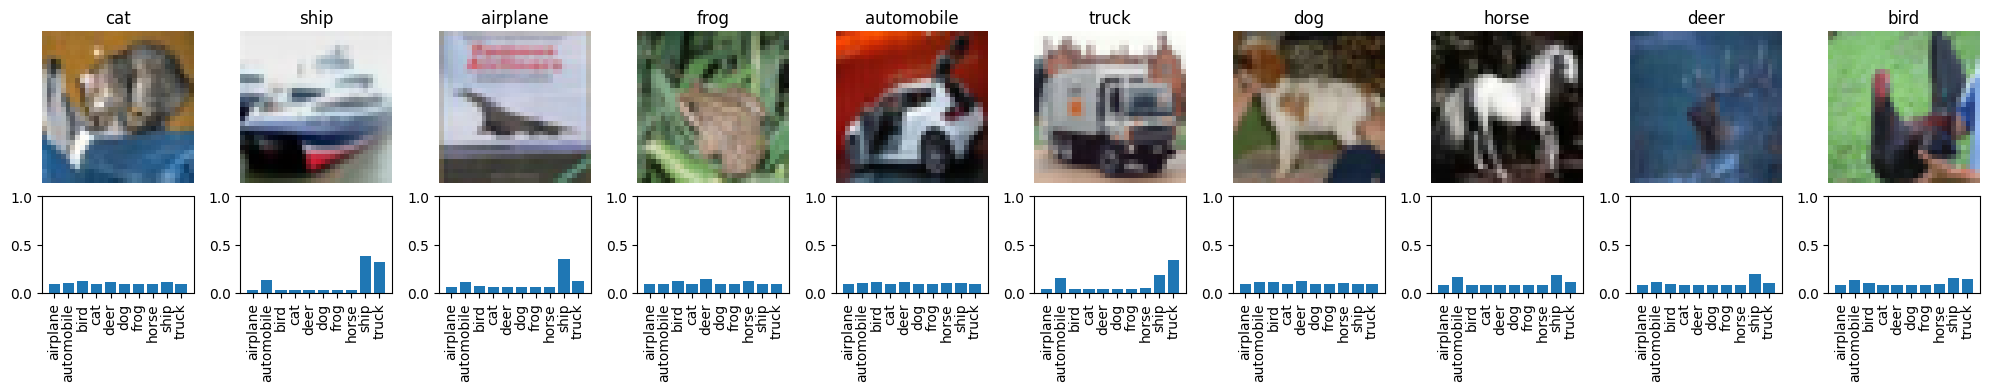

Epoch 3 - training loss: 0.00213


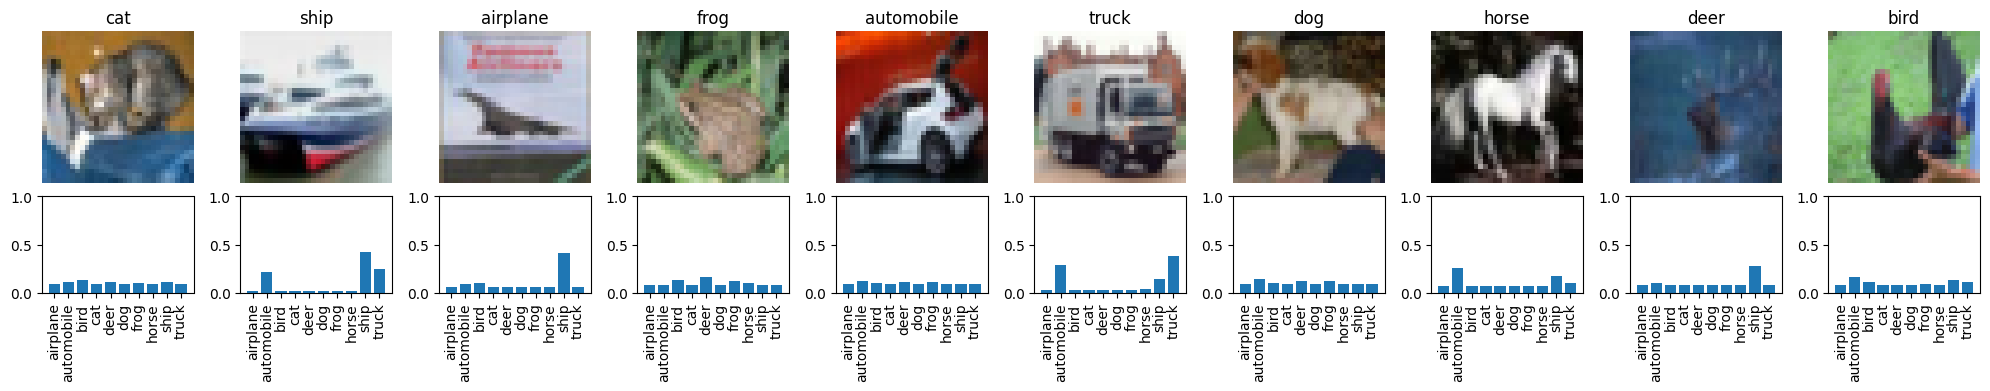

Epoch 4 - training loss: 0.00207


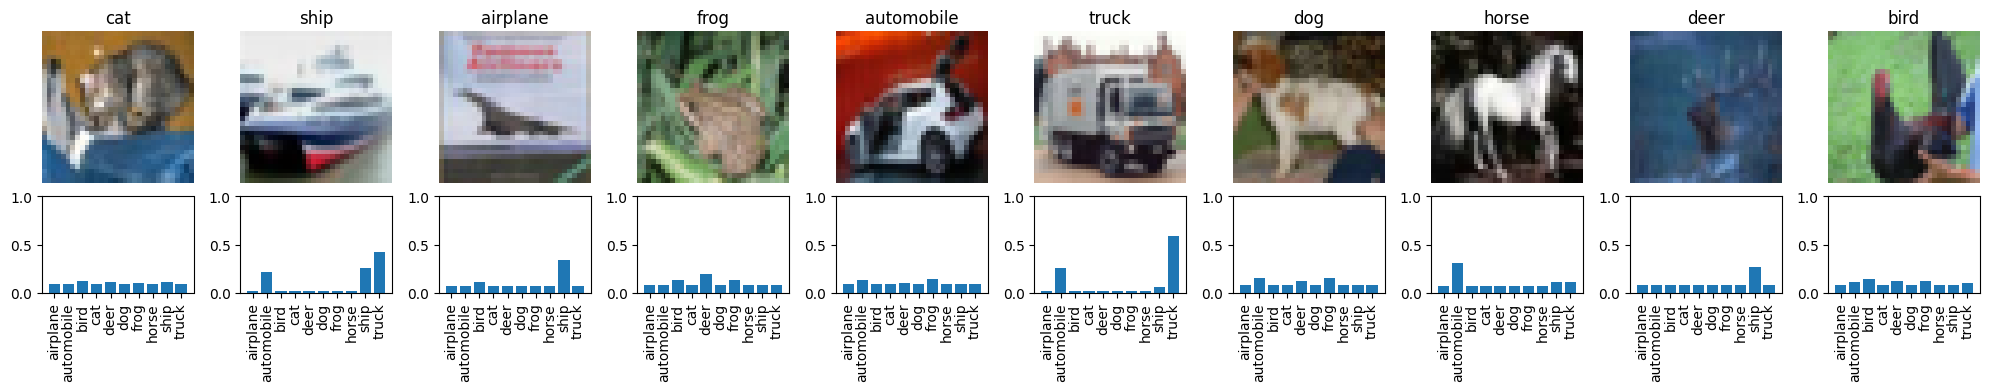

Epoch 5 - training loss: 0.00204


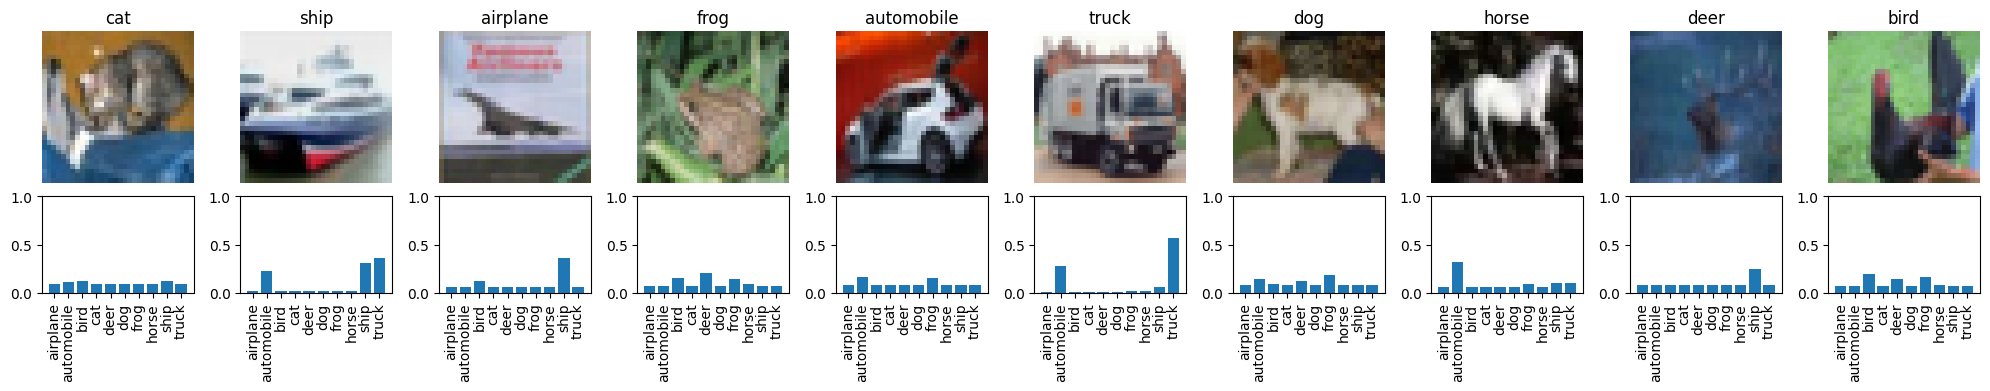

In [14]:
for j in range(n_epochs):
    current_loss = 0
    for i, data in enumerate(trainloader, 0):
        X_train_, y_train_ = data
        optimizer.zero_grad()
        y_pred = model(X_train_.reshape(-1, n_inputs))
        loss = criterion(y_pred, y_train_)
        loss.backward()  # backward learning pass
        optimizer.step()
        current_loss += loss.item()

    # Print the loss for the current epoch
    print(f"Epoch {j + 1} - training loss: {current_loss/len(train_set):.5f}")
    
    # Visualize the training on validation set
    # Plot the images and their predicted probabilities
    fig, axes = plt.subplots(2, len(class_labels), figsize=(20, 4), gridspec_kw={'height_ratios': [2, 1]})
    model.eval()  # Set the model to evaluation mode

    for i, (label, (image, _)) in enumerate(first_images.items()):
        # Prepare the image for the model
        image_input = image.unsqueeze(0).reshape(-1, n_inputs)

        # Predict the probabilities
        with torch.no_grad():
            probabilities = torch.softmax(model(image_input), dim=1).squeeze()

        # Plot the image
        axes[0, i].imshow(image.permute(1, 2, 0))  # Convert from CHW to HWC format
        axes[0, i].axis('off')
        axes[0, i].set_title(class_labels[label])

        # Plot the probabilities
        axes[1, i].bar(class_labels, probabilities.numpy())
        axes[1, i].set_xticks(range(len(class_labels)))
        axes[1, i].set_xticklabels(class_labels, rotation=90)
        axes[1, i].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

Feel free to play around with the parameters of the model to improve training!